In this notebook, we will be training an image classification model with the pre-trained weights of MobileNetV2 network along with an adversarial training objective. We will be using the [`Neural Structured Learning`](https://www.tensorflow.org/neural_structured_learning) (NSL) library from TensorFlow for this purpose. We will also be comparing the adversarially trained model to the regular image classification model as shown in this notebook (TODO: update link). 

## Initial setup

In [1]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
# Which GPU?
!nvidia-smi

Fri Oct 23 12:44:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Other imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

# Fix the seeds
SEED = 666
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Flowers dataset

In [4]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

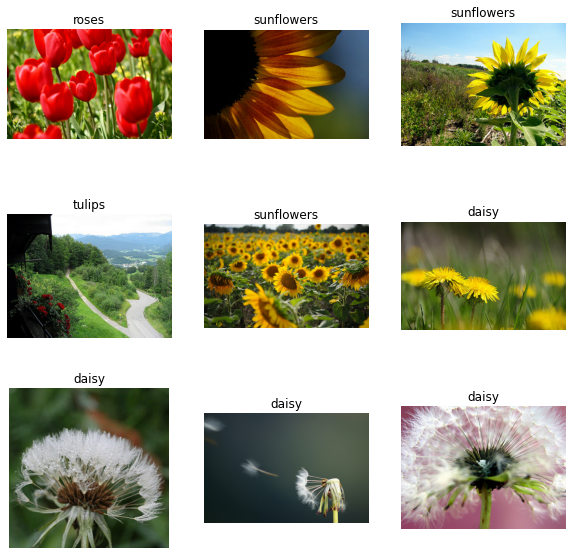

In [5]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[int(label)])
    plt.axis("off")

## Data preparation

In [6]:
# Image preprocessing utils

SIZE = (224, 224)

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, SIZE)
    return (image, label)

In [7]:
# Construct TensorFlow dataset
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

# Construct TensorFlow dataset
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Model training utils

In [8]:
def get_training_model(base_model):
    inputs = Input(shape=(224, 224, 3), name="image")
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(5, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

In [9]:
# Load the MobileNetV2 model but exclude the classification layers
mn = MobileNetV2(weights="imagenet", include_top=False)
mn.trainable = False 
get_training_model(mn).summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Model training

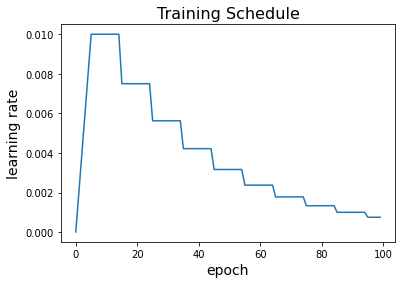

In [10]:
# CUSTOM LEARNING SCHEUDLE
# Reference: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
LR_START = 1e-5
LR_MAX = 1e-2
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

In [11]:
# Early stopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
49/49 [==============================] - 8s 169ms/step - loss: 1.8978 - accuracy: 0.2583 - val_loss: 1.9329 - val_accuracy: 0.2436

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0020080000000000002.
Epoch 2/30
49/49 [==============================] - 5s 94ms/step - loss: 0.7253 - accuracy: 0.7349 - val_loss: 0.4165 - val_accuracy: 0.8655

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004006.
Epoch 3/30
49/49 [==============================] - 5s 94ms/step - loss: 0.3778 - accuracy: 0.8734 - val_loss: 0.3417 - val_accuracy: 0.8836

Epoch 00004: LearningRateScheduler reducing learning rate to 0.006004000000000001.
Epoch 4/30
49/49 [==============================] - 5s 94ms/step - loss: 0.2839 - accuracy: 0.9071 - val_loss: 0.3206 - val_accuracy: 0.8891

Epoch 00005: LearningRateScheduler reducing learning rate to 0.008002.
Epoch 5/30
49/49 [==============================] - 5

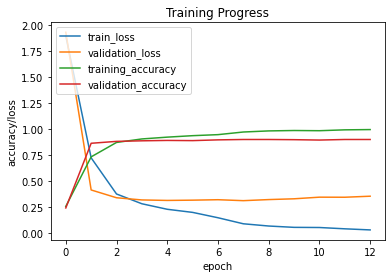

In [12]:
# Train the model
model_mn = get_training_model(mn)
model_mn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time.time()
h = model_mn.fit(train_ds,
              validation_data=validation_ds,
              epochs=30,
              callbacks=[lr2, es])
print("Total training time (seconds): ",time.time()-start)
plot_progress(h)

## Sample predictions

In [13]:
# Utility to plot sample predictions 
def plot_predictions(images, labels, probability):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image.numpy())
        predicted_label = CLASSES[np.argmax(probability[i])]
        maximum_probability = "{:.3f}".format(max(probability[i]))
        text = "{} with probability: {}".format(predicted_label, maximum_probability) + \
            "\nGround-truth: {}".format(CLASSES[int(labels[i])])
        plt.title(text)
        plt.axis("off")
    plt.show()

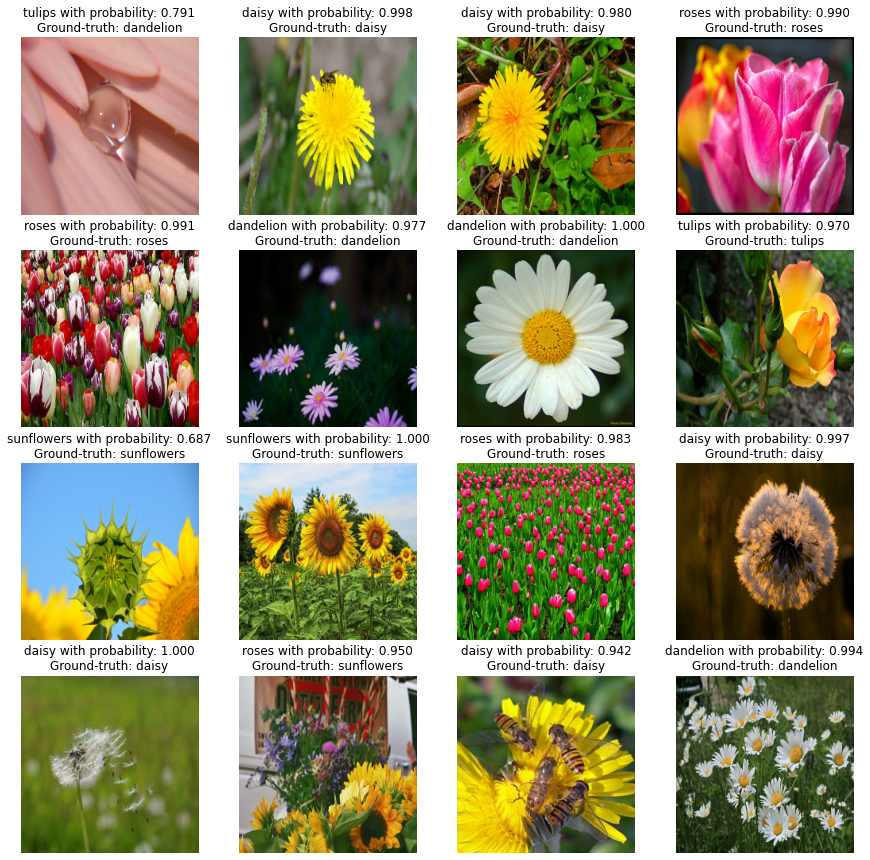

In [14]:
# Let's run inference on a batch of images from the validation set
(batch_images, batch_labels) = next(iter(validation_ds))
predictions = model_mn.predict(batch_images)
plot_predictions(batch_images[:16], batch_labels[:16], predictions[:16])

## Adversarial training with `neural_structured_learning`

In [15]:
# Setup Neural Structured Learning
!pip install -q neural-structured-learning
import neural_structured_learning as nsl

NSL expects the data to be present in a slightly different format than what Keras would expect. So, we need to make the changes accordingly.

In [16]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, SIZE)
    return {"image": image, "label": label}

# Construct TensorFlow dataset
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [19]:
# Configuration for adversarial training
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=0.3,
    adv_step_size=0.1,
    adv_grad_norm="infinity"
)

Here are some more details about the hyperparameters we used above - 
- `adv_multiplier`: The weight of adversarial loss in the training objective, relative to the labeled loss.
- `adv_step_size`: The magnitude of adversarial perturbation.
- `adv_grad_norm`: The norm to measure the magnitude of adversarial perturbation.

In [20]:
# This time we are not training the base model
base_model = MobileNetV2(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
base_model.trainable = False
base_adv_model = get_training_model(base_model)

# Create and compile the adv. model
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    adv_config=adv_config
)

adv_model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

# Train the model
start = time.time()
h = adv_model.fit(train_ds,
                  validation_data=validation_ds,
                  epochs=10)
print("Total training time (seconds): ",time.time()-start)

Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fb290956e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fb290956e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fb290956e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


     49/Unknown - 16s 318ms/step - loss: 1.4005 - sparse_categorical_crossentropy: 0.8893 - sparse_categorical_accuracy: 0.6715 - scaled_adversarial_loss: 0.5112WARNING:tensorflow:The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


49/49 [==============================] - 21s 426ms/step - loss: 1.4005 - sparse_categorical_crossentropy: 0.8893 - sparse_categorical_accuracy: 0.6715 - scaled_adversarial_loss: 0.5112 - val_loss: 0.9699 - val_sparse_categorical_crossentropy: 0.5314 - val_sparse_categorical_accuracy: 0.8255 - val_scaled_adversarial_loss: 0.4385
Epoch 2/10
49/49 [==============================] - 18s 358ms/step - loss: 0.9047 - sparse_categorical_crossentropy: 0.4748 - sparse_categorical_accuracy: 0.8423 - scaled_adversarial_loss: 0.4299 - val_loss: 0.8352 - val_sparse_categorical_crossentropy: 0.4250 - val_sparse_categorical_accuracy: 0.8509 - val_scaled_adversarial_loss: 0.4103
Epoch 3/10
49/49 [==============================] - 18s 362ms/step - loss: 0.8033 - sparse_categorical_crossentropy: 0.3968 - sparse_categorical_accuracy: 0.8728 - scaled_adversarial_loss: 0.4065 - val_loss: 0.7766 - val_sparse_categorical_crossentropy: 0.3773 - val_sparse_categorical_accuracy: 0.8727 - val_scaled_adversarial_l

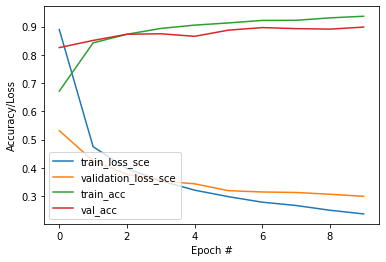

In [21]:
plt.figure()
plt.plot(h.history["sparse_categorical_crossentropy"], label="train_loss_sce")
plt.plot(h.history["val_sparse_categorical_crossentropy"], label="validation_loss_sce")
plt.plot(h.history["sparse_categorical_accuracy"], label="train_acc")
plt.plot(h.history["val_sparse_categorical_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="lower left")
plt.show()

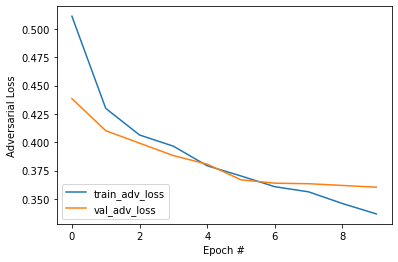

In [22]:
plt.figure()
plt.plot(h.history["scaled_adversarial_loss"], label="train_adv_loss")
plt.plot(h.history["val_scaled_adversarial_loss"], label="val_adv_loss")
plt.xlabel("Epoch #")
plt.ylabel("Adversarial Loss")
plt.legend(loc="lower left")
plt.show()

## Evaluating the adversarially trained model

Now, we will test the robustness of the above two models under adversarial perturbations as shown in [this tutorial](https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist#robustness_under_adversarial_perturbations). Most of the code below comes from that tutorial itself.

In [23]:
# Compile the base model after wrapping it with `AdversarialRegularization`
# Needed to generate perturbated samples
reference_model = nsl.keras.AdversarialRegularization(
    model_mn,
    adv_config=adv_config)
reference_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [24]:
# Models to be evaluated
models_to_eval = {
    'base': model_mn,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [25]:
# Comes from the above-mentioned tutorial with some modification
perturbed_images, labels, predictions = [], [], []

for batch in validation_ds:
    perturbed_batch = reference_model.perturb_on_batch(batch)
    # Clipping makes perturbed examples have the same range as regular ones.
    perturbed_batch["image"] = tf.clip_by_value(                          
        perturbed_batch["image"], 0.0, 1.0)
    y_true = perturbed_batch.pop("label")
    perturbed_images.append(perturbed_batch["image"].numpy())
    labels.append(y_true.numpy())
    predictions.append({})
    for name, model in models_to_eval.items():
        y_pred = model(perturbed_batch)
        metrics[name](y_true, y_pred)
        predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
    print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.307273
adv-regularized model accuracy: 0.574545


accuracy in batch 1:
base model: 11 / 32
adv-regularized model: 16 / 32


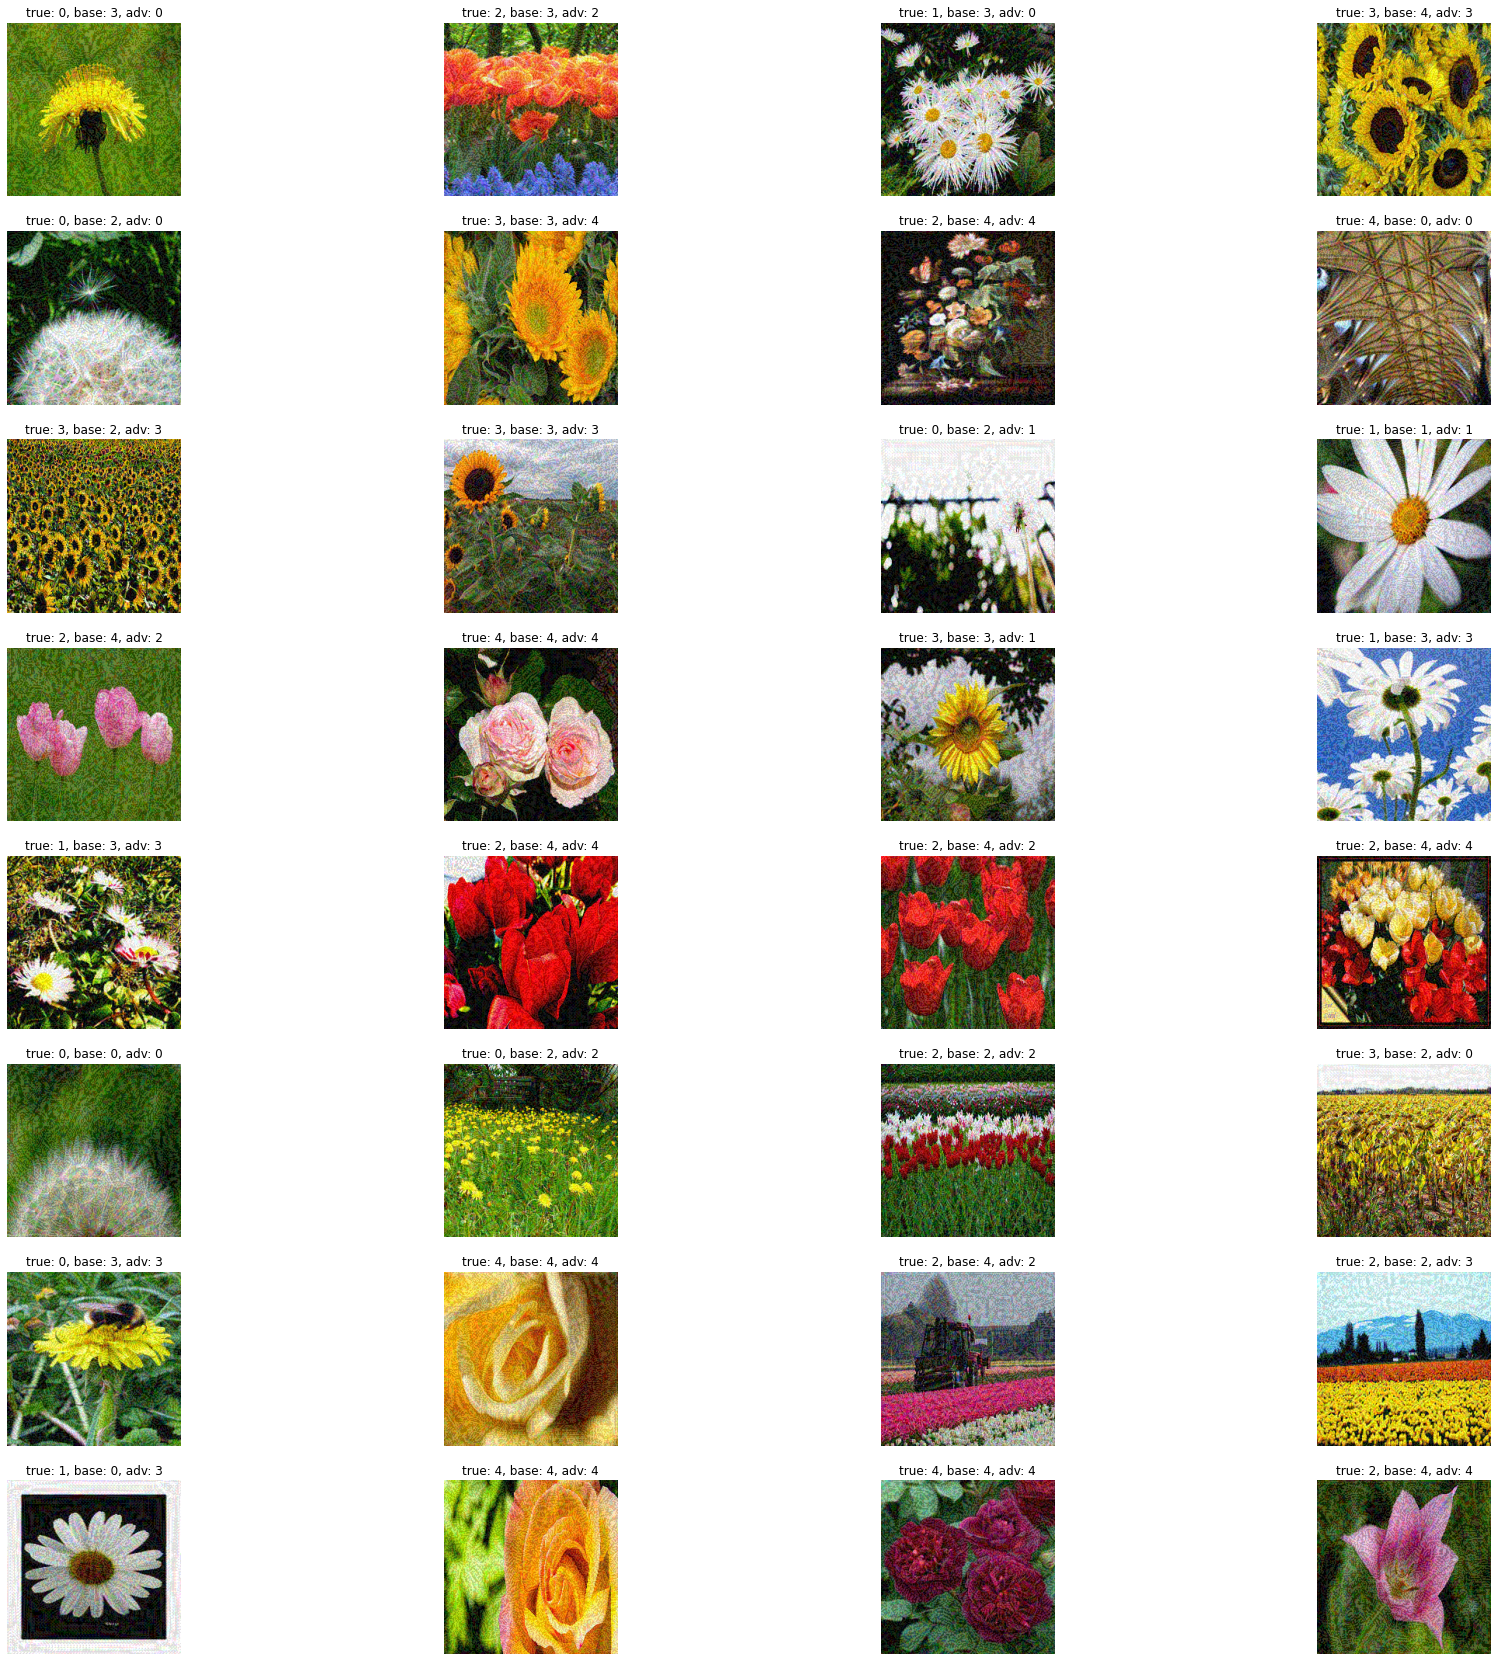

In [26]:
# Comes from the above-mentioned tutorial with some modification
batch_index = 1 # Change as needed

batch_image = perturbed_images[batch_index][:32]
batch_label = labels[batch_index][:32]
batch_pred = predictions[batch_index]

batch_size = 32
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
    print('%s model: %d / %d' % (name, np.sum(batch_label == pred[:32]), batch_size))

plt.figure(figsize=(30, 30))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
    y_base = batch_pred['base'][i]
    y_adv = batch_pred['adv-regularized'][i]
    # y = np.argmax(y)
    plt.subplot(n_row, n_col, i+1)
    plt.title('true: {}, base: {}, adv: {}'.format(y, y_base, y_adv))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')

plt.show()